## RECS system update with MLP
## Date: 19 MARCH 2021 at 1:10 PM

In [21]:
#============================
# Import important libraries
#============================
import pandas as pd 
import numpy as np
import scipy
import pywt
import math
import seaborn as sns
from creme import metrics
import time
import datetime

from statistics import mode
from sklearn.metrics import mutual_info_score

from scipy import stats
from sklearn import preprocessing

from collections import defaultdict, Counter
from scipy.special import expit

from ANN_cls import *
from mRMR import *

from window_slider import Slider


from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [22]:
# #==========================================
# #  Feature extraction EEG wavelet features
# #==========================================
# def eeg_features(y, level = 5, wavelet = 'db4'):
#     from math import log
#     fv = []
#     n = len(y)

#     sig = y

#     ap = {}

#     for lev in range(0,level):
#         (y, cD) = pywt.dwt(y, wavelet)
#         ap[lev] = y

#     # Energy

#     Enr = np.zeros(level)
#     for lev in range(0,level):
#         Enr[lev] = np.sum(np.power(ap[lev],2))/n

#     Et = np.sum(Enr)

#     Pi = np.zeros(level)
#     for lev in range(0,level):
#         Pi[lev] = Enr[lev]/Et

#     we = - np.sum(np.dot(Pi,np.log(Pi)))

#     return np.mean(Enr), np.mean(Pi), we

In [45]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [median, mean, std, var, rms]

def get_features(list_values):    
#     list_values = list_values[0,:]
    entropy = calculate_entropy(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + statistics

In [46]:
def eeg_features(raw_data):
    ch = 0
    features= []
    for i in range(window_data.shape[0]):
        ch_data = window_data[i]
        list_coeff = pywt.wavedec(ch_data, 'db4', level=5)
        for coeff in list_coeff:
            features += get_features(coeff)
            
        ch = ch+1
    return features

In [47]:
##===================================================
# EEG data read from files
##===================================================
def eeg_data(p,v):
    file_eeg = '/home/gp/Desktop/MER_arin/data/eeg_data/'+str(p)+'_data_DEAP'+'.csv'
    print(file_eeg)
    df = pd.read_csv(file_eeg,sep=',', header = None)
    eeg_sig = df.loc[df.iloc[:,1] == v]
    return eeg_sig

In [64]:
#=======================================
# MAIN PROGRAM STARTS HERE
#=======================================
segment_in_sec = 10 #in sec
bucket_size = int((8064/60)*segment_in_sec)  #8064 is for 60 sec record
print(bucket_size)
overlap_count = 0

l_max =0.9999
lr_min = 0.0001
eta_init = 1
b =1 


n_epoch =1
epochs =  1 #epoch is 1 because the model will be trained only once
# optimizer= 'sgd' #optimizer

optimizer= 'sgd' #optimizer
classifier = 'ALR-mlp-'+str(optimizer)
c = 0
run = 1

participant = 32
videos = 40

global eeg_emotion
eeg_emotion = []


all_eta =[]
init_m = 0

#================================================
# Performance matric declaration here
#================================================

eeg_acc_val = metrics.Accuracy() #Accuracy
eeg_f1m_val = metrics.F1() #F1 measure  
eeg_acc_aro = metrics.Accuracy() #Accuracy
eeg_f1m_aro = metrics.F1() #F1 measure
eeg_mse_val = metrics.MSE() #MSE measure
eeg_mse_aro = metrics.MSE() #MSE measure
    
itr = 0 #controls the learning rate


for ii in range(0,participant):


#         if(ii >1):
#         	break

        p =ii+1
        for jj in range(0,videos):
            v = jj+1
            p_v = 'Person:'+ ' ' +str(p)+ ' ' +'Video:'+str(v)
            
            eta = 0.05
#             eta =eta_init/(1+(b*eta_init*itr))
            itr = itr+1
            
#             eta = lr_max*(lr_max-lr_min)/itr) #increasing Learning rate
            
#             eta = lr_max - eta*np.tanh((lr_max-lr_min)/lr_max) #decreasing Learning rate
                    
            print('learning rate:',eta)
            
            print('------------------------------------------------')
            
            ##===================================================
            # EEG data read from files
            ##===================================================
            eeg_sig = eeg_data(p,v) 
            
            #=================================================
            #emotion labels (valence, arousal) mapping 0-1
            #=================================================
            val = eeg_sig.iloc[0,8067]
            aro = eeg_sig.iloc[0,8068]
            
            #valence emotion maping 0-> low valence and 1-> high valence

            if (val >5):
                vl = 1 #high valence
            else:
                vl = 0 #low valence

            #arousal emotion maping 0-> low arousal and 1-> high high arousal
            if (aro >5):
                al = 1 #high arousal
            else:
                al = 0 #low arousal
                
            y_act_val = vl
            y_act_aro = al 
            
            #=========================================
            # Sliding window starts here 
            #=========================================
            slider = Slider(bucket_size,overlap_count)
            eeg_sig = np.array(eeg_sig.iloc[range(0,32),range(3,8067)]) #keeping only eeg signals
            
#             print(eeg_sig.shape)
            slider.fit(eeg_sig)   

            while True:
                window_data = slider.slide()
                # do your stuff
#                 print(window_data.shape)                
                
                #=================================================
                # Feature extraction from EEG
                #=================================================
                features_eeg = eeg_features(window_data)
                eeg = np.array([features_eeg])  #EEG raw feature vector
                
                x_eeg = preprocessing.normalize(eeg) # EEG normalized features [0,1] 
                
                eeg_size_hidden = 30 #math.ceil(eeg.shape[1]*(2/3)) #Hidden node size

                #===================================================
                # Model initialization
                #===================================================
                if init_m == 0:

                    #========================
                    # For EEG data MLP model
                    #========================
                    eeg_model_val = ANN()
                    eeg_model_val.add(layers.layer(x_eeg.shape[1], 'sigmoid'))
                    eeg_model_val.add(layers.layer(eeg_size_hidden, 'sigmoid'))
                    eeg_model_val.add(layers.layer(1, 'sigmoid'))


                    eeg_model_aro = ANN()
                    eeg_model_aro.add(layers.layer(x_eeg.shape[1], 'sigmoid'))
                    eeg_model_aro.add(layers.layer(eeg_size_hidden, 'sigmoid'))
                    eeg_model_aro.add(layers.layer(1, 'sigmoid'))


                    init_m = init_m+1


                #===============================================================
                # Emotion Classification --> Valence and Arousal
                #===============================================================

                #Valence classification EEG

                #Test the model first 
                y_pred_val_eeg = eeg_model_val.predict_once(x_eeg,c)

                #Train the model once
                eeg_model_val.fit_once(x_eeg,y_act_val, eta,c)

                eeg_acc_val = eeg_acc_val.update(y_act_val, y_pred_val_eeg)  # update the accuracy metric

                eeg_f1m_val = eeg_f1m_val.update(y_act_val, y_pred_val_eeg) #update f1 measure metric

                #Arousal classification EEG

                #Test the model first 
                y_pred_aro_eeg = eeg_model_aro.predict_once(x_eeg,c)

                #Train the model once
                eeg_model_aro.fit_once(x_eeg,y_act_aro, eta,c)

                eeg_acc_aro = eeg_acc_aro.update(y_act_aro, y_pred_aro_eeg)  # update the accuracy metric

                eeg_f1m_aro = eeg_f1m_aro.update(y_act_aro, y_pred_aro_eeg) #update f1 measure metric
                
                c = c+1
                if slider.reached_end_of_list(): break


            print(p_v)

            eeg_emotion.append(np.array([p,v,eeg_acc_val.get(), eeg_f1m_val.get(), eeg_acc_aro.get(), eeg_f1m_aro.get(), y_act_val, y_pred_val_eeg, y_act_aro, y_pred_aro_eeg]))

            print('===============================================================')
            print('Actual emotion [valence: {}, arousal: {}]'.format(y_act_val, y_act_aro))
            print('Predicted emotion valence:{}, arousal:{}'.format(y_pred_val_eeg, y_pred_aro_eeg))        
            print('..................................................')
            print('EEG')

            print("Valence Accuracy:{}".format(round(eeg_acc_val.get(),4)))
            print("Valence F1 score:{}".format(round(eeg_f1m_val.get(),4)))
            print("Arousal Accuracy:{}".format(round(eeg_acc_val.get(),4)))
            print("Arousal F1 score:{}".format(round(eeg_f1m_val.get(),4)))
            print('==========================================================================')
                
                

1344
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
Person: 1 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.6667
Valence F1 score:0.8
Arousal Accuracy:0.6667
Arousal F1 score:0.8
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
Person: 1 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.8333
Valence F1 score:0.9091
Arousal Accuracy:0.8333
Arousal F1 score:0.9091
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
Person: 1 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
...............

Person: 1 Video:17
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7647
Valence F1 score:0.7647
Arousal Accuracy:0.7647
Arousal F1 score:0.7647
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
Person: 1 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7407
Valence F1 score:0.7455
Arousal Accuracy:0.7407
Arousal F1 score:0.7455
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
Person: 1 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7544
Valence F1 score:0.7705
Arousal Accuracy:0.7544
Arousal F

Person: 1 Video:33
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7929
Valence F1 score:0.8194
Arousal Accuracy:0.7929
Arousal F1 score:0.8194
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
Person: 1 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.799
Valence F1 score:0.8194
Arousal Accuracy:0.799
Arousal F1 score:0.8194
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/1_data_DEAP.csv
Person: 1 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.8048
Valence F1 score:0.8194
Arousal Accuracy:0.8048
Arousal F1 

Person: 2 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.8061
Valence F1 score:0.8213
Arousal Accuracy:0.8061
Arousal F1 score:0.8213
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/2_data_DEAP.csv
Person: 2 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7933
Valence F1 score:0.8086
Arousal Accuracy:0.7933
Arousal F1 score:0.8086
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/2_data_DEAP.csv
Person: 2 Video:11
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7908
Valence F1 score:0.8084
Arousal Accuracy:0.7908
Arousal F1

Person: 2 Video:25
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.8128
Valence F1 score:0.8437
Arousal Accuracy:0.8128
Arousal F1 score:0.8437
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/2_data_DEAP.csv
Person: 2 Video:26
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.8157
Valence F1 score:0.8476
Arousal Accuracy:0.8157
Arousal F1 score:0.8476
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/2_data_DEAP.csv
Person: 2 Video:27
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.8109
Valence F1 score:0.8423
Arousal Accuracy:0.8109
Arousal F

Person: 3 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.8169
Valence F1 score:0.8279
Arousal Accuracy:0.8169
Arousal F1 score:0.8279
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/3_data_DEAP.csv
Person: 3 Video:2
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.8191
Valence F1 score:0.8318
Arousal Accuracy:0.8191
Arousal F1 score:0.8318
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/3_data_DEAP.csv
Person: 3 Video:3
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.8213
Valence F1 score:0.8355
Arousal Accuracy:0.8213
Arousal F1 s

Person: 3 Video:17
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.8093
Valence F1 score:0.837
Arousal Accuracy:0.8093
Arousal F1 score:0.837
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/3_data_DEAP.csv
Person: 3 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.8078
Valence F1 score:0.8365
Arousal Accuracy:0.8078
Arousal F1 score:0.8365
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/3_data_DEAP.csv
Person: 3 Video:19
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.8098
Valence F1 score:0.8393
Arousal Accuracy:0.8098
Arousal F1 

Person: 3 Video:33
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7935
Valence F1 score:0.8153
Arousal Accuracy:0.7935
Arousal F1 score:0.8153
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/3_data_DEAP.csv
Person: 3 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7939
Valence F1 score:0.8142
Arousal Accuracy:0.7939
Arousal F1 score:0.8142
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/3_data_DEAP.csv
Person: 3 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7942
Valence F1 score:0.8132
Arousal Accuracy:0.7942
Arousal F

Person: 4 Video:9
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7739
Valence F1 score:0.7953
Arousal Accuracy:0.7739
Arousal F1 score:0.7953
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/4_data_DEAP.csv
Person: 4 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7705
Valence F1 score:0.7916
Arousal Accuracy:0.7705
Arousal F1 score:0.7916
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/4_data_DEAP.csv
Person: 4 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7697
Valence F1 score:0.7917
Arousal Accuracy:0.7697
Arousal F1

Person: 4 Video:25
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7575
Valence F1 score:0.7781
Arousal Accuracy:0.7575
Arousal F1 score:0.7781
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/4_data_DEAP.csv
Person: 4 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7568
Valence F1 score:0.7784
Arousal Accuracy:0.7568
Arousal F1 score:0.7784
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/4_data_DEAP.csv
Person: 4 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7585
Valence F1 score:0.7811
Arousal Accuracy:0.7585
Arousal F

Person: 5 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7671
Valence F1 score:0.772
Arousal Accuracy:0.7671
Arousal F1 score:0.772
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/5_data_DEAP.csv
Person: 5 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7665
Valence F1 score:0.7723
Arousal Accuracy:0.7665
Arousal F1 score:0.7723
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/5_data_DEAP.csv
Person: 5 Video:3
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7638
Valence F1 score:0.7692
Arousal Accuracy:0.7638
Arousal F1 sco

Person: 5 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7589
Valence F1 score:0.7735
Arousal Accuracy:0.7589
Arousal F1 score:0.7735
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/5_data_DEAP.csv
Person: 5 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.7758
Arousal Accuracy:0.7603
Arousal F1 score:0.7758
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/5_data_DEAP.csv
Person: 5 Video:19
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7616
Valence F1 score:0.7782
Arousal Accuracy:0.7616
Arousal F

Person: 5 Video:33
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7556
Valence F1 score:0.772
Arousal Accuracy:0.7556
Arousal F1 score:0.772
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/5_data_DEAP.csv
Person: 5 Video:34
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7552
Valence F1 score:0.7722
Arousal Accuracy:0.7552
Arousal F1 score:0.7722
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/5_data_DEAP.csv
Person: 5 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7513
Valence F1 score:0.7685
Arousal Accuracy:0.7513
Arousal F1 

Person: 6 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7616
Valence F1 score:0.7822
Arousal Accuracy:0.7616
Arousal F1 score:0.7822
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/6_data_DEAP.csv
Person: 6 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7627
Valence F1 score:0.7841
Arousal Accuracy:0.7627
Arousal F1 score:0.7841
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/6_data_DEAP.csv
Person: 6 Video:11
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7591
Valence F1 score:0.7807
Arousal Accuracy:0.7591
Arousal F1

Person: 6 Video:25
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7637
Valence F1 score:0.7919
Arousal Accuracy:0.7637
Arousal F1 score:0.7919
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/6_data_DEAP.csv
Person: 6 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.764
Valence F1 score:0.7927
Arousal Accuracy:0.764
Arousal F1 score:0.7927
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/6_data_DEAP.csv
Person: 6 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7651
Valence F1 score:0.7943
Arousal Accuracy:0.7651
Arousal F1 

Person: 7 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7503
Valence F1 score:0.7805
Arousal Accuracy:0.7503
Arousal F1 score:0.7805
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/7_data_DEAP.csv
Person: 7 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7507
Valence F1 score:0.7814
Arousal Accuracy:0.7507
Arousal F1 score:0.7814
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/7_data_DEAP.csv
Person: 7 Video:3
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.751
Valence F1 score:0.7822
Arousal Accuracy:0.751
Arousal F1 sco

Person: 7 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7974
Arousal Accuracy:0.7601
Arousal F1 score:0.7974
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/7_data_DEAP.csv
Person: 7 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.798
Arousal Accuracy:0.7603
Arousal F1 score:0.798
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/7_data_DEAP.csv
Person: 7 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7613
Valence F1 score:0.7994
Arousal Accuracy:0.7613
Arousal F1 

Person: 7 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.754
Valence F1 score:0.7887
Arousal Accuracy:0.754
Arousal F1 score:0.7887
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/7_data_DEAP.csv
Person: 7 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7543
Valence F1 score:0.7883
Arousal Accuracy:0.7543
Arousal F1 score:0.7883
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/7_data_DEAP.csv
Person: 7 Video:35
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7527
Valence F1 score:0.7871
Arousal Accuracy:0.7527
Arousal F1 

Person: 8 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7578
Valence F1 score:0.7969
Arousal Accuracy:0.7578
Arousal F1 score:0.7969
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/8_data_DEAP.csv
Person: 8 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7563
Valence F1 score:0.7954
Arousal Accuracy:0.7563
Arousal F1 score:0.7954
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/8_data_DEAP.csv
Person: 8 Video:11
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7566
Valence F1 score:0.796
Arousal Accuracy:0.7566
Arousal F1 

Person: 8 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7585
Valence F1 score:0.7978
Arousal Accuracy:0.7585
Arousal F1 score:0.7978
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/8_data_DEAP.csv
Person: 8 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7593
Valence F1 score:0.7978
Arousal Accuracy:0.7593
Arousal F1 score:0.7978
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/8_data_DEAP.csv
Person: 8 Video:27
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7978
Arousal Accuracy:0.76
Arousal F1 sc

Person: 9 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7529
Valence F1 score:0.789
Arousal Accuracy:0.7529
Arousal F1 score:0.789
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/9_data_DEAP.csv
Person: 9 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7521
Valence F1 score:0.7885
Arousal Accuracy:0.7521
Arousal F1 score:0.7885
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/9_data_DEAP.csv
Person: 9 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7528
Valence F1 score:0.7896
Arousal Accuracy:0.7528
Arousal F1 sco

Person: 9 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7537
Valence F1 score:0.7932
Arousal Accuracy:0.7537
Arousal F1 score:0.7932
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/9_data_DEAP.csv
Person: 9 Video:18
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7525
Valence F1 score:0.7919
Arousal Accuracy:0.7525
Arousal F1 score:0.7919
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/9_data_DEAP.csv
Person: 9 Video:19
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7532
Valence F1 score:0.7919
Arousal Accuracy:0.7532
Arousal F

Person: 9 Video:33
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7493
Valence F1 score:0.7835
Arousal Accuracy:0.7493
Arousal F1 score:0.7835
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/9_data_DEAP.csv
Person: 9 Video:34
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7476
Valence F1 score:0.7821
Arousal Accuracy:0.7476
Arousal F1 score:0.7821
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/9_data_DEAP.csv
Person: 9 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7479
Valence F1 score:0.7818
Arousal Accuracy:0.7479
Arousal F

Person: 10 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7502
Valence F1 score:0.7844
Arousal Accuracy:0.7502
Arousal F1 score:0.7844
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/10_data_DEAP.csv
Person: 10 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7505
Valence F1 score:0.7849
Arousal Accuracy:0.7505
Arousal F1 score:0.7849
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/10_data_DEAP.csv
Person: 10 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7511
Valence F1 score:0.7859
Arousal Accuracy:0.7511
Arous

Person: 10 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7476
Valence F1 score:0.7842
Arousal Accuracy:0.7476
Arousal F1 score:0.7842
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/10_data_DEAP.csv
Person: 10 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7478
Valence F1 score:0.7839
Arousal Accuracy:0.7478
Arousal F1 score:0.7839
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/10_data_DEAP.csv
Person: 10 Video:27
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7485
Valence F1 score:0.7839
Arousal Accuracy:0.7485
Arou

Person: 11 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.751
Valence F1 score:0.7808
Arousal Accuracy:0.751
Arousal F1 score:0.7808
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/11_data_DEAP.csv
Person: 11 Video:2
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7512
Valence F1 score:0.7813
Arousal Accuracy:0.7512
Arousal F1 score:0.7813
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/11_data_DEAP.csv
Person: 11 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7519
Valence F1 score:0.7823
Arousal Accuracy:0.7519
Arousal F

Person: 11 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7562
Valence F1 score:0.7907
Arousal Accuracy:0.7562
Arousal F1 score:0.7907
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/11_data_DEAP.csv
Person: 11 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7564
Valence F1 score:0.7911
Arousal Accuracy:0.7564
Arousal F1 score:0.7911
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/11_data_DEAP.csv
Person: 11 Video:19
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.757
Valence F1 score:0.792
Arousal Accuracy:0.757
Arousal

Person: 11 Video:33
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.756
Valence F1 score:0.7892
Arousal Accuracy:0.756
Arousal F1 score:0.7892
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/11_data_DEAP.csv
Person: 11 Video:34
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.755
Valence F1 score:0.7882
Arousal Accuracy:0.755
Arousal F1 score:0.7882
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/11_data_DEAP.csv
Person: 11 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7548
Valence F1 score:0.7877
Arousal Accuracy:0.7548
Arousal 

Person: 12 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7584
Valence F1 score:0.7906
Arousal Accuracy:0.7584
Arousal F1 score:0.7906
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/12_data_DEAP.csv
Person: 12 Video:10
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.757
Valence F1 score:0.7893
Arousal Accuracy:0.757
Arousal F1 score:0.7893
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/12_data_DEAP.csv
Person: 12 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7898
Arousal Accuracy:0.7572
Arousal

Person: 12 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7602
Valence F1 score:0.7931
Arousal Accuracy:0.7602
Arousal F1 score:0.7931
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/12_data_DEAP.csv
Person: 12 Video:26
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7593
Valence F1 score:0.7923
Arousal Accuracy:0.7593
Arousal F1 score:0.7923
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/12_data_DEAP.csv
Person: 12 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7598
Valence F1 score:0.7931
Arousal Accuracy:0.7598
Arou

Person: 13 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7899
Arousal Accuracy:0.7606
Arousal F1 score:0.7899
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/13_data_DEAP.csv
Person: 13 Video:2
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7593
Valence F1 score:0.7887
Arousal Accuracy:0.7593
Arousal F1 score:0.7887
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/13_data_DEAP.csv
Person: 13 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7591
Valence F1 score:0.7887
Arousal Accuracy:0.7591
Arousal

Person: 13 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7569
Valence F1 score:0.7879
Arousal Accuracy:0.7569
Arousal F1 score:0.7879
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/13_data_DEAP.csv
Person: 13 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7574
Valence F1 score:0.7887
Arousal Accuracy:0.7574
Arousal F1 score:0.7887
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/13_data_DEAP.csv
Person: 13 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7887
Arousal Accuracy:0.7572
Arou

Person: 13 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7557
Valence F1 score:0.7853
Arousal Accuracy:0.7557
Arousal F1 score:0.7853
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/13_data_DEAP.csv
Person: 13 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7562
Valence F1 score:0.7853
Arousal Accuracy:0.7562
Arousal F1 score:0.7853
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/13_data_DEAP.csv
Person: 13 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7566
Valence F1 score:0.7853
Arousal Accuracy:0.7566
Arou

Person: 14 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7583
Valence F1 score:0.7866
Arousal Accuracy:0.7583
Arousal F1 score:0.7866
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/14_data_DEAP.csv
Person: 14 Video:10
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7575
Valence F1 score:0.7858
Arousal Accuracy:0.7575
Arousal F1 score:0.7858
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/14_data_DEAP.csv
Person: 14 Video:11
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7577
Valence F1 score:0.7861
Arousal Accuracy:0.7577
Arous

Person: 14 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7581
Valence F1 score:0.7872
Arousal Accuracy:0.7581
Arousal F1 score:0.7872
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/14_data_DEAP.csv
Person: 14 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7585
Valence F1 score:0.7872
Arousal Accuracy:0.7585
Arousal F1 score:0.7872
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/14_data_DEAP.csv
Person: 14 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7578
Valence F1 score:0.7866
Arousal Accuracy:0.7578
Arou

Person: 15 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7605
Valence F1 score:0.7856
Arousal Accuracy:0.7605
Arousal F1 score:0.7856
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/15_data_DEAP.csv
Person: 15 Video:2
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.761
Valence F1 score:0.7863
Arousal Accuracy:0.761
Arousal F1 score:0.7863
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/15_data_DEAP.csv
Person: 15 Video:3
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7614
Valence F1 score:0.787
Arousal Accuracy:0.7614
Arousal F1

Person: 15 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7637
Valence F1 score:0.7924
Arousal Accuracy:0.7637
Arousal F1 score:0.7924
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/15_data_DEAP.csv
Person: 15 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7641
Valence F1 score:0.793
Arousal Accuracy:0.7641
Arousal F1 score:0.793
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/15_data_DEAP.csv
Person: 15 Video:19
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7645
Valence F1 score:0.7936
Arousal Accuracy:0.7645
Arousa

Person: 15 Video:33
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7648
Valence F1 score:0.7907
Arousal Accuracy:0.7648
Arousal F1 score:0.7907
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/15_data_DEAP.csv
Person: 15 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7652
Valence F1 score:0.7907
Arousal Accuracy:0.7652
Arousal F1 score:0.7907
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/15_data_DEAP.csv
Person: 15 Video:35
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7639
Valence F1 score:0.7895
Arousal Accuracy:0.7639
Arou

Person: 16 Video:9
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7638
Valence F1 score:0.788
Arousal Accuracy:0.7638
Arousal F1 score:0.788
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/16_data_DEAP.csv
Person: 16 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7628
Valence F1 score:0.7872
Arousal Accuracy:0.7628
Arousal F1 score:0.7872
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/16_data_DEAP.csv
Person: 16 Video:11
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.763
Valence F1 score:0.7875
Arousal Accuracy:0.763
Arousal F

Person: 16 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7619
Valence F1 score:0.7837
Arousal Accuracy:0.7619
Arousal F1 score:0.7837
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/16_data_DEAP.csv
Person: 16 Video:26
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.762
Valence F1 score:0.7835
Arousal Accuracy:0.762
Arousal F1 score:0.7835
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/16_data_DEAP.csv
Person: 16 Video:27
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7618
Valence F1 score:0.7832
Arousal Accuracy:0.7618
Arousa

Person: 17 Video:1
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7795
Arousal Accuracy:0.76
Arousal F1 score:0.7795
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/17_data_DEAP.csv
Person: 17 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7593
Valence F1 score:0.7789
Arousal Accuracy:0.7593
Arousal F1 score:0.7789
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/17_data_DEAP.csv
Person: 17 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7592
Valence F1 score:0.779
Arousal Accuracy:0.7592
Arousal F1 s

Person: 17 Video:17
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7825
Arousal Accuracy:0.76
Arousal F1 score:0.7825
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/17_data_DEAP.csv
Person: 17 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7596
Valence F1 score:0.7823
Arousal Accuracy:0.7596
Arousal F1 score:0.7823
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/17_data_DEAP.csv
Person: 17 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7826
Arousal Accuracy:0.7597
Arousal 

Person: 17 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7578
Valence F1 score:0.7788
Arousal Accuracy:0.7578
Arousal F1 score:0.7788
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/17_data_DEAP.csv
Person: 17 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7582
Valence F1 score:0.7788
Arousal Accuracy:0.7582
Arousal F1 score:0.7788
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/17_data_DEAP.csv
Person: 17 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7585
Valence F1 score:0.7788
Arousal Accuracy:0.7585
Arou

Person: 18 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7815
Arousal Accuracy:0.76
Arousal F1 score:0.7815
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/18_data_DEAP.csv
Person: 18 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7821
Arousal Accuracy:0.7604
Arousal F1 score:0.7821
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/18_data_DEAP.csv
Person: 18 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7826
Arousal Accuracy:0.7607
Arousal F

Person: 18 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7612
Valence F1 score:0.7845
Arousal Accuracy:0.7612
Arousal F1 score:0.7845
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/18_data_DEAP.csv
Person: 18 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7837
Arousal Accuracy:0.7604
Arousal F1 score:0.7837
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/18_data_DEAP.csv
Person: 18 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7843
Arousal Accuracy:0.7607
Arou

Person: 19 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7822
Arousal Accuracy:0.7607
Arousal F1 score:0.7822
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/19_data_DEAP.csv
Person: 19 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7608
Valence F1 score:0.7825
Arousal Accuracy:0.7608
Arousal F1 score:0.7825
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/19_data_DEAP.csv
Person: 19 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7609
Valence F1 score:0.7828
Arousal Accuracy:0.7609
Arousal

Person: 19 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7641
Valence F1 score:0.7886
Arousal Accuracy:0.7641
Arousal F1 score:0.7886
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/19_data_DEAP.csv
Person: 19 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7645
Valence F1 score:0.7891
Arousal Accuracy:0.7645
Arousal F1 score:0.7891
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/19_data_DEAP.csv
Person: 19 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7648
Valence F1 score:0.7896
Arousal Accuracy:0.7648
Arou

Person: 19 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7618
Valence F1 score:0.7857
Arousal Accuracy:0.7618
Arousal F1 score:0.7857
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/19_data_DEAP.csv
Person: 19 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7615
Valence F1 score:0.7852
Arousal Accuracy:0.7615
Arousal F1 score:0.7852
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/19_data_DEAP.csv
Person: 19 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7618
Valence F1 score:0.7852
Arousal Accuracy:0.7618
Arou

Person: 20 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7629
Valence F1 score:0.787
Arousal Accuracy:0.7629
Arousal F1 score:0.787
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/20_data_DEAP.csv
Person: 20 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7632
Valence F1 score:0.7875
Arousal Accuracy:0.7632
Arousal F1 score:0.7875
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/20_data_DEAP.csv
Person: 20 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7635
Valence F1 score:0.788
Arousal Accuracy:0.7635
Arousal 

Person: 20 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7648
Valence F1 score:0.7902
Arousal Accuracy:0.7648
Arousal F1 score:0.7902
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/20_data_DEAP.csv
Person: 20 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7648
Valence F1 score:0.7901
Arousal Accuracy:0.7648
Arousal F1 score:0.7901
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/20_data_DEAP.csv
Person: 20 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7643
Valence F1 score:0.7896
Arousal Accuracy:0.7643
Arou

Person: 21 Video:1
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7643
Valence F1 score:0.7874
Arousal Accuracy:0.7643
Arousal F1 score:0.7874
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/21_data_DEAP.csv
Person: 21 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7641
Valence F1 score:0.7874
Arousal Accuracy:0.7641
Arousal F1 score:0.7874
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/21_data_DEAP.csv
Person: 21 Video:3
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7638
Valence F1 score:0.787
Arousal Accuracy:0.7638
Arousal 

Person: 21 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7644
Valence F1 score:0.7896
Arousal Accuracy:0.7644
Arousal F1 score:0.7896
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/21_data_DEAP.csv
Person: 21 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7647
Valence F1 score:0.79
Arousal Accuracy:0.7647
Arousal F1 score:0.79
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/21_data_DEAP.csv
Person: 21 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.765
Valence F1 score:0.7905
Arousal Accuracy:0.765
Arousal F1

Person: 21 Video:33
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7647
Valence F1 score:0.7883
Arousal Accuracy:0.7647
Arousal F1 score:0.7883
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/21_data_DEAP.csv
Person: 21 Video:34
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7642
Valence F1 score:0.7877
Arousal Accuracy:0.7642
Arousal F1 score:0.7877
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/21_data_DEAP.csv
Person: 21 Video:35
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7637
Valence F1 score:0.7871
Arousal Accuracy:0.7637
Arou

Person: 22 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7621
Valence F1 score:0.7865
Arousal Accuracy:0.7621
Arousal F1 score:0.7865
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/22_data_DEAP.csv
Person: 22 Video:10
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7614
Valence F1 score:0.7859
Arousal Accuracy:0.7614
Arousal F1 score:0.7859
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/22_data_DEAP.csv
Person: 22 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7611
Valence F1 score:0.7857
Arousal Accuracy:0.7611
Arous

Person: 22 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7853
Arousal Accuracy:0.7607
Arousal F1 score:0.7853
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/22_data_DEAP.csv
Person: 22 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.761
Valence F1 score:0.7853
Arousal Accuracy:0.761
Arousal F1 score:0.7853
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/22_data_DEAP.csv
Person: 22 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.7847
Arousal Accuracy:0.7603
Arousa

Person: 23 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7616
Valence F1 score:0.7832
Arousal Accuracy:0.7616
Arousal F1 score:0.7832
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/23_data_DEAP.csv
Person: 23 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7615
Valence F1 score:0.7832
Arousal Accuracy:0.7615
Arousal F1 score:0.7832
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/23_data_DEAP.csv
Person: 23 Video:3
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7618
Valence F1 score:0.7837
Arousal Accuracy:0.7618
Arousal

Person: 23 Video:17
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7642
Valence F1 score:0.7883
Arousal Accuracy:0.7642
Arousal F1 score:0.7883
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/23_data_DEAP.csv
Person: 23 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7643
Valence F1 score:0.7885
Arousal Accuracy:0.7643
Arousal F1 score:0.7885
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/23_data_DEAP.csv
Person: 23 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7644
Valence F1 score:0.7888
Arousal Accuracy:0.7644
Arou

Person: 23 Video:33
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7616
Valence F1 score:0.786
Arousal Accuracy:0.7616
Arousal F1 score:0.786
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/23_data_DEAP.csv
Person: 23 Video:34
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7617
Valence F1 score:0.7862
Arousal Accuracy:0.7617
Arousal F1 score:0.7862
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/23_data_DEAP.csv
Person: 23 Video:35
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7619
Valence F1 score:0.7866
Arousal Accuracy:0.7619
Arousa

Person: 24 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7853
Arousal Accuracy:0.7601
Arousal F1 score:0.7853
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/24_data_DEAP.csv
Person: 24 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7857
Arousal Accuracy:0.7604
Arousal F1 score:0.7857
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/24_data_DEAP.csv
Person: 24 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7605
Valence F1 score:0.7859
Arousal Accuracy:0.7605
Arous

Person: 24 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7859
Arousal Accuracy:0.7607
Arousal F1 score:0.7859
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/24_data_DEAP.csv
Person: 24 Video:26
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7609
Valence F1 score:0.7859
Arousal Accuracy:0.7609
Arousal F1 score:0.7859
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/24_data_DEAP.csv
Person: 24 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7605
Valence F1 score:0.7855
Arousal Accuracy:0.7605
Arou

Person: 25 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7614
Valence F1 score:0.7838
Arousal Accuracy:0.7614
Arousal F1 score:0.7838
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/25_data_DEAP.csv
Person: 25 Video:2
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7614
Valence F1 score:0.7837
Arousal Accuracy:0.7614
Arousal F1 score:0.7837
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/25_data_DEAP.csv
Person: 25 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7612
Valence F1 score:0.7835
Arousal Accuracy:0.7612
Arousal

Person: 25 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.761
Valence F1 score:0.7844
Arousal Accuracy:0.761
Arousal F1 score:0.7844
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/25_data_DEAP.csv
Person: 25 Video:18
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7602
Valence F1 score:0.7837
Arousal Accuracy:0.7602
Arousal F1 score:0.7837
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/25_data_DEAP.csv
Person: 25 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.7839
Arousal Accuracy:0.7603
Arousa

Person: 25 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7591
Valence F1 score:0.7823
Arousal Accuracy:0.7591
Arousal F1 score:0.7823
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/25_data_DEAP.csv
Person: 25 Video:34
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7594
Valence F1 score:0.7823
Arousal Accuracy:0.7594
Arousal F1 score:0.7823
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/25_data_DEAP.csv
Person: 25 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7596
Valence F1 score:0.7823
Arousal Accuracy:0.7596
Arou

Person: 26 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7822
Arousal Accuracy:0.7597
Arousal F1 score:0.7822
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/26_data_DEAP.csv
Person: 26 Video:10
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7589
Valence F1 score:0.7815
Arousal Accuracy:0.7589
Arousal F1 score:0.7815
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/26_data_DEAP.csv
Person: 26 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7588
Valence F1 score:0.7815
Arousal Accuracy:0.7588
Arous

Person: 26 Video:25
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7607
Valence F1 score:0.7852
Arousal Accuracy:0.7607
Arousal F1 score:0.7852
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/26_data_DEAP.csv
Person: 26 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7851
Arousal Accuracy:0.7604
Arousal F1 score:0.7851
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/26_data_DEAP.csv
Person: 26 Video:27
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7855
Arousal Accuracy:0.7606
Arou

Person: 27 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.7839
Arousal Accuracy:0.7606
Arousal F1 score:0.7839
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/27_data_DEAP.csv
Person: 27 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7606
Valence F1 score:0.784
Arousal Accuracy:0.7606
Arousal F1 score:0.784
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/27_data_DEAP.csv
Person: 27 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7605
Valence F1 score:0.784
Arousal Accuracy:0.7605
Arousal F1

Person: 27 Video:17
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7847
Arousal Accuracy:0.7597
Arousal F1 score:0.7847
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/27_data_DEAP.csv
Person: 27 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.785
Arousal Accuracy:0.7599
Arousal F1 score:0.785
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/27_data_DEAP.csv
Person: 27 Video:19
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7602
Valence F1 score:0.7854
Arousal Accuracy:0.7602
Arousa

Person: 27 Video:33
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7611
Valence F1 score:0.788
Arousal Accuracy:0.7611
Arousal F1 score:0.788
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/27_data_DEAP.csv
Person: 27 Video:34
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7604
Valence F1 score:0.7874
Arousal Accuracy:0.7604
Arousal F1 score:0.7874
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/27_data_DEAP.csv
Person: 27 Video:35
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7867
Arousal Accuracy:0.7597
Arousa

Person: 28 Video:9
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.7878
Arousal Accuracy:0.7599
Arousal F1 score:0.7878
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/28_data_DEAP.csv
Person: 28 Video:10
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.7881
Arousal Accuracy:0.7601
Arousal F1 score:0.7881
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/28_data_DEAP.csv
Person: 28 Video:11
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.7885
Arousal Accuracy:0.7603
Arous

Person: 28 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.76
Valence F1 score:0.7889
Arousal Accuracy:0.76
Arousal F1 score:0.7889
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/28_data_DEAP.csv
Person: 28 Video:26
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.7887
Arousal Accuracy:0.7599
Arousal F1 score:0.7887
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/28_data_DEAP.csv
Person: 28 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7596
Valence F1 score:0.7884
Arousal Accuracy:0.7596
Arousal 

Person: 29 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7583
Valence F1 score:0.7863
Arousal Accuracy:0.7583
Arousal F1 score:0.7863
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/29_data_DEAP.csv
Person: 29 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7582
Valence F1 score:0.7863
Arousal Accuracy:0.7582
Arousal F1 score:0.7863
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/29_data_DEAP.csv
Person: 29 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7584
Valence F1 score:0.7866
Arousal Accuracy:0.7584
Arousal

Person: 29 Video:17
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7595
Valence F1 score:0.7892
Arousal Accuracy:0.7595
Arousal F1 score:0.7892
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/29_data_DEAP.csv
Person: 29 Video:18
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7594
Valence F1 score:0.7892
Arousal Accuracy:0.7594
Arousal F1 score:0.7892
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/29_data_DEAP.csv
Person: 29 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7596
Valence F1 score:0.7895
Arousal Accuracy:0.7596
Arou

Person: 29 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.788
Arousal Accuracy:0.7599
Arousal F1 score:0.788
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/29_data_DEAP.csv
Person: 29 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7601
Valence F1 score:0.788
Arousal Accuracy:0.7601
Arousal F1 score:0.788
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/29_data_DEAP.csv
Person: 29 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7603
Valence F1 score:0.788
Arousal Accuracy:0.7603
Arousal F

Person: 30 Video:9
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7595
Valence F1 score:0.7884
Arousal Accuracy:0.7595
Arousal F1 score:0.7884
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/30_data_DEAP.csv
Person: 30 Video:10
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7597
Valence F1 score:0.7887
Arousal Accuracy:0.7597
Arousal F1 score:0.7887
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/30_data_DEAP.csv
Person: 30 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7599
Valence F1 score:0.789
Arousal Accuracy:0.7599
Arousa

Person: 30 Video:25
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7592
Valence F1 score:0.7892
Arousal Accuracy:0.7592
Arousal F1 score:0.7892
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/30_data_DEAP.csv
Person: 30 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7587
Valence F1 score:0.7888
Arousal Accuracy:0.7587
Arousal F1 score:0.7888
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/30_data_DEAP.csv
Person: 30 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7589
Valence F1 score:0.7891
Arousal Accuracy:0.7589
Arou

Person: 31 Video:1
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7573
Valence F1 score:0.7871
Arousal Accuracy:0.7573
Arousal F1 score:0.7871
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/31_data_DEAP.csv
Person: 31 Video:2
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7872
Arousal Accuracy:0.7572
Arousal F1 score:0.7872
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/31_data_DEAP.csv
Person: 31 Video:3
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7573
Valence F1 score:0.7873
Arousal Accuracy:0.7573
Arousal

Person: 31 Video:17
Actual emotion [valence: 0, arousal: 0]
Predicted emotion valence:[0.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7571
Valence F1 score:0.7883
Arousal Accuracy:0.7571
Arousal F1 score:0.7883
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/31_data_DEAP.csv
Person: 31 Video:18
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7573
Valence F1 score:0.7886
Arousal Accuracy:0.7573
Arousal F1 score:0.7886
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/31_data_DEAP.csv
Person: 31 Video:19
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7572
Valence F1 score:0.7886
Arousal Accuracy:0.7572
Arou

Person: 31 Video:33
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7559
Valence F1 score:0.7875
Arousal Accuracy:0.7559
Arousal F1 score:0.7875
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/31_data_DEAP.csv
Person: 31 Video:34
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7561
Valence F1 score:0.7875
Arousal Accuracy:0.7561
Arousal F1 score:0.7875
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/31_data_DEAP.csv
Person: 31 Video:35
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7563
Valence F1 score:0.7875
Arousal Accuracy:0.7563
Arou

Person: 32 Video:9
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[1.], arousal:[0.]
..................................................
EEG
Valence Accuracy:0.7569
Valence F1 score:0.7877
Arousal Accuracy:0.7569
Arousal F1 score:0.7877
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/32_data_DEAP.csv
Person: 32 Video:10
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7565
Valence F1 score:0.7873
Arousal Accuracy:0.7565
Arousal F1 score:0.7873
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/32_data_DEAP.csv
Person: 32 Video:11
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[1.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7565
Valence F1 score:0.7873
Arousal Accuracy:0.7565
Arous

Person: 32 Video:25
Actual emotion [valence: 0, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7565
Valence F1 score:0.7877
Arousal Accuracy:0.7565
Arousal F1 score:0.7877
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/32_data_DEAP.csv
Person: 32 Video:26
Actual emotion [valence: 1, arousal: 0]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.7561
Valence F1 score:0.7873
Arousal Accuracy:0.7561
Arousal F1 score:0.7873
learning rate: 0.05
------------------------------------------------
/home/gp/Desktop/MER_arin/data/eeg_data/32_data_DEAP.csv
Person: 32 Video:27
Actual emotion [valence: 1, arousal: 1]
Predicted emotion valence:[0.], arousal:[1.]
..................................................
EEG
Valence Accuracy:0.756
Valence F1 score:0.7873
Arousal Accuracy:0.756
Arousa

In [65]:
time_stamp = datetime.datetime.now()
fname_eeg = 'Run_'+str(run)+'_'+str(time_stamp)+'_all_person_EEG'+'_' +classifier+'_results.csv'
np.savetxt(fname_eeg,eeg_emotion, delimiter ="\t", fmt =['%d', '%d', '%f', '%f', '%f', '%f','%d','%d','%d','%d'], comments='', 
    header='Person, Video, Acc_val, F1_val,Acc_aro,F1_aro, y_act_val, y_pred_val, y_act_aro, y_pred_aro')

EEG Valence accuracy:0.83046875
EEG Valence F1 Score:0.8518771331058022
Valence Confiusion matric:
[[439 133]
 [ 84 624]]
 
EEG Valence Classification Report
              precision    recall  f1-score   support

         Low       0.84      0.77      0.80       572
        High       0.82      0.88      0.85       708

    accuracy                           0.83      1280
   macro avg       0.83      0.82      0.83      1280
weighted avg       0.83      0.83      0.83      1280

EEG Arousal accuracy:
0.82734375
 
EEG Arousal F1 Score
0.8523714094856379
 
EEG Arousal Confiusion matric
[[421 122]
 [ 99 638]]
 
EEG Arousal classification Report
              precision    recall  f1-score   support

         Low       0.81      0.78      0.79       543
        High       0.84      0.87      0.85       737

    accuracy                           0.83      1280
   macro avg       0.82      0.82      0.82      1280
weighted avg       0.83      0.83      0.83      1280



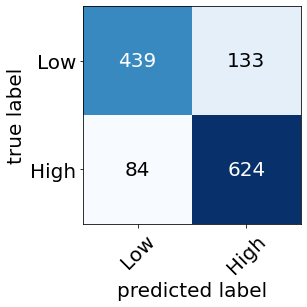

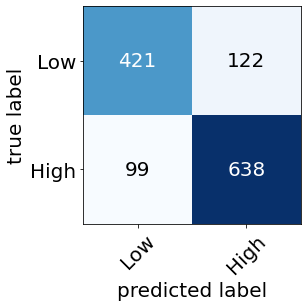

In [66]:
#===============================
# EEG results
#===============================

df = pd.read_csv(fname_eeg)
# print(df)
val_true = df.iloc[:,6]
val_prdt = df.iloc[:,7]
aro_true = df.iloc[:,8]
aro_prdt = df.iloc[:,9]

#============================================
# Valence Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


val_y_true = val_true #Acutal class labels

val_y_pred = val_prdt #Predicted Class labels

cm = confusion_matrix(val_y_true, val_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

val_c_report = classification_report(val_y_true, val_y_pred, target_names=target_names) #Classification report

val_acc_score = accuracy_score(val_y_true, val_y_pred) #Balanced accuracy Score calculation

val_f1_scr = f1_score(val_y_true, val_y_pred)

print('EEG Valence accuracy:{}'.format(val_acc_score))
print('EEG Valence F1 Score:{}'.format(val_f1_scr))
print('Valence Confiusion matric:')
print(cm)

print(' ')

# print('Accuracy score', acc_score)

print('EEG Valence Classification Report')
print(val_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(1)
# plt.show()

fname1 = str(time_stamp)+ classifier+ ' valence EEG.jpeg'

plt.savefig(fname1, bbox_inches='tight')


#============================================
# Arousal Classification Report
#============================================
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


aro_y_true = aro_true #Acutal class labels

aro_y_pred = aro_prdt #Predicted Class labels

cm = confusion_matrix(aro_y_true, aro_y_pred) # Confusion Matrix

target_names = ['Low','High'] # Class names

aro_c_report = classification_report(aro_y_true, aro_y_pred, target_names=target_names) #Classification report


aro_acc_score = accuracy_score(aro_y_true, aro_y_pred) #Balanced accuracy Score calculation

aro_f1_scr = f1_score(aro_y_true, aro_y_pred)

print('EEG Arousal accuracy:')
print(aro_acc_score)

print(' ')
print('EEG Arousal F1 Score')
print(aro_f1_scr)

print(' ')

print('EEG Arousal Confiusion matric')
print(cm)

print(' ')

print('EEG Arousal classification Report')
print(aro_c_report)

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = target_names

## Plot Confusion matric Valence 
## ================================
plt.rcParams.update({'font.size': 20})
fig1, ax1 = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
#                                 show_normed=True,
#                                 colorbar=True,
                                  class_names=class_names)
plt.figure(2)
# plt.show()

fname2 = str(time_stamp)+classifier+'arousal EEG.jpeg'

plt.savefig(fname2, bbox_inches='tight')